In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bionetgen
#import roadrunner

# Load model from BNGL
model_name='mm'
model = bionetgen.bngmodel(model_name + '.bngl') 
sim = model.setup_simulator() # sim is a libroadrunner simulator object
onames= [ o for o in model.observables]
pnames= [p for p in model.parameters]
pvals= np.array([eval(model.parameters[p].value) for p in pnames])
fnames= [f for f in model.functions]

## Read data from file

In [131]:
fitdata = pd.read_csv(model_name+'.csv', header=0, delimiter=",") #reads in data file
tdat= fitdata['Time'].values
odat= fitdata[onames[-1]].values # ensure compatibility of data and last observable

## Function to run simulation of model with input parameter vector

In [132]:
def run_model(sim,times,params):
    # Set model parameter values 
    for i in range(len(params)):
        sim[pnames[i]]= params[i]
    # Reset simulator to t=0 and update parameter values
    sim.reset()
    res= sim.simulate(times=times,selections=onames)
    return(res)

In [133]:
def cost(pvals):
    res= run_model(sim,tdat,pvals)
    y=res[onames[-1]]
    sigma= odat.copy()
    sigma[0]=1.
    nll= np.sum(((y-odat)/(sigma))**2)# chi^2
    return(nll) # negative log likelihood - smaller is better

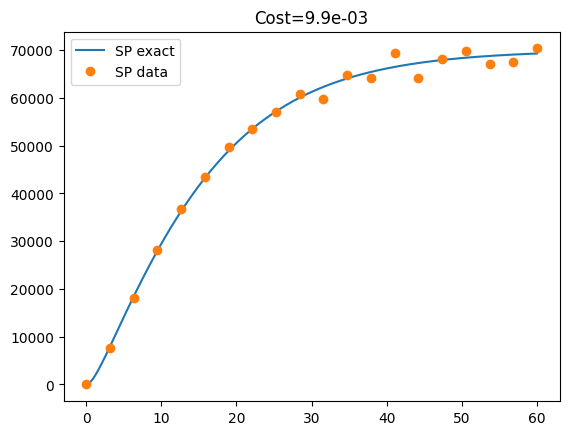

In [134]:
tsim= np.linspace(tdat[0],tdat[-1],200)
# Plot comparison
def plot_comparison(p):
    o=onames[-1]
    res= run_model(sim,tsim,p)
    plt.plot(tsim,res[o],label=o + ' exact')
    plt.plot(fitdata['Time'].values, fitdata[onames[-1]].values, 'o', label=o+' data')  
    plt.title(f'Cost={cost(p):0.1e}')
    _= plt.legend()

plot_comparison(pvals)

## Set up cost function

In [135]:
cost(pvals)

0.00989610082220827

## User PyPesto package to perform parameter estimation

In [136]:
import pypesto
import pypesto.optimize as optimize
#import pypesto.petab
import pypesto.visualize as visualize

# log scale parameters to improve optimization 
cost_pp= lambda p: cost(10**p)
# Set upper and lower bounds on parameters
ub= np.log10(pvals) + 2
lb= np.log10(pvals) - 2

# create pypesto problem
model_loss= pypesto.Objective(fun=cost_pp)
problem = pypesto.Problem(objective=model_loss, x_names=pnames, lb=lb, ub=ub)

### Perform optimization

100%|██████████| 100/100 [00:05<00:00, 17.98it/s]


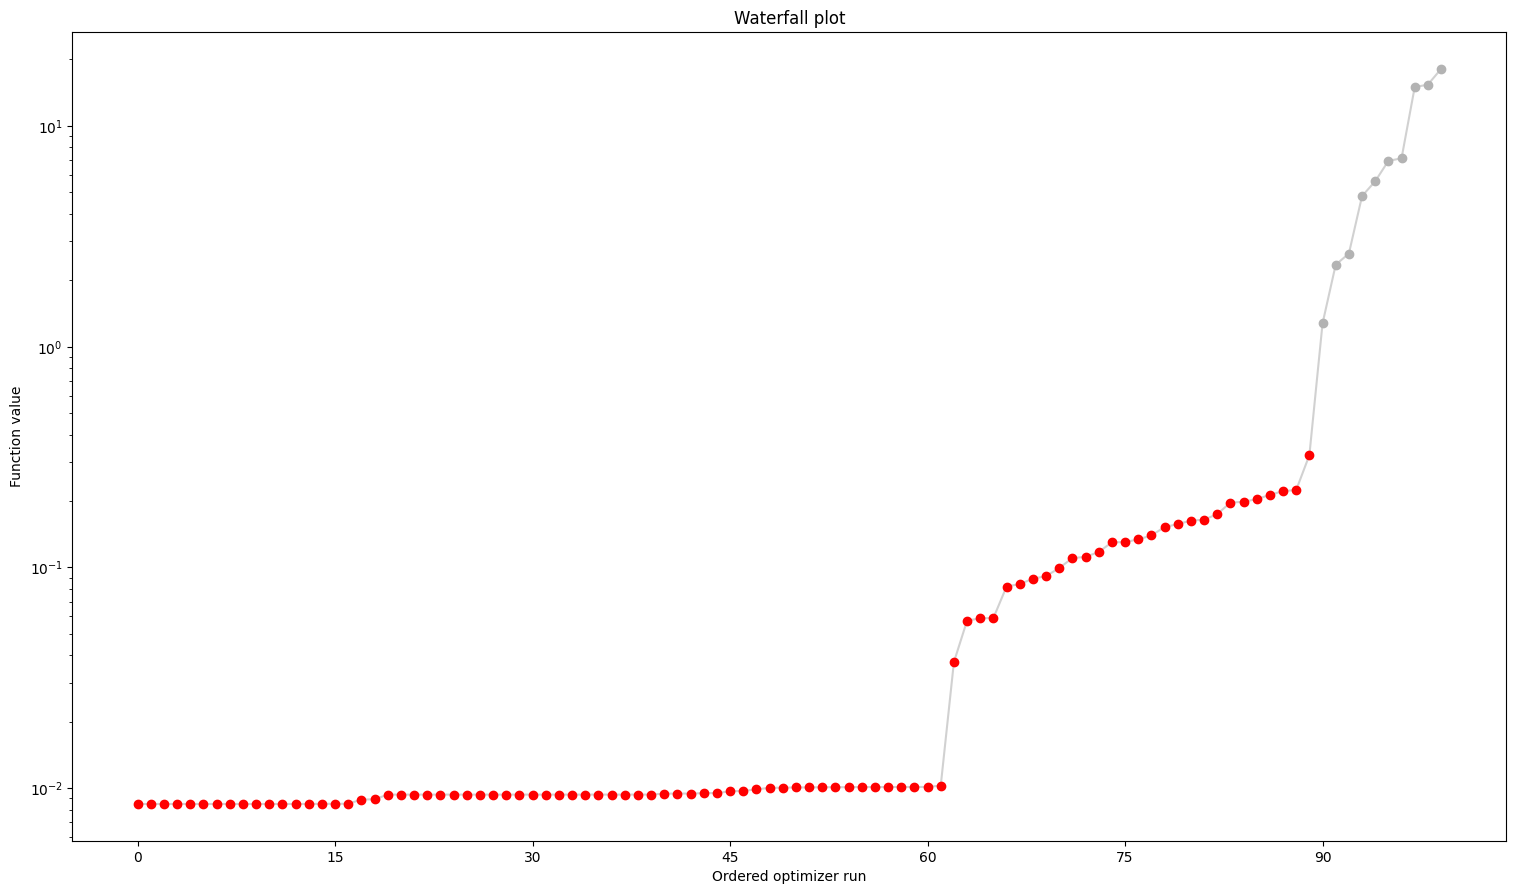

In [137]:
# choose optimizer
optimizer = optimize.ScipyOptimizer(method='L-BFGS-B')

# do the optimization
result = optimize.minimize(
    problem=problem, optimizer=optimizer, n_starts=100
)

_=pypesto.visualize.waterfall(result,offset_y=0,scale_y='log10')

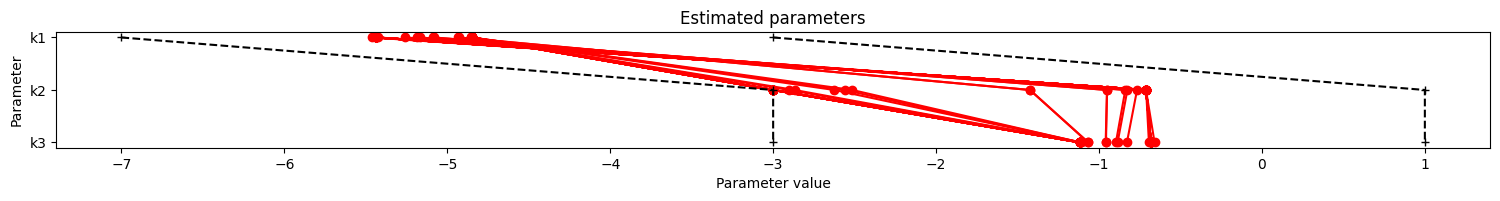

In [138]:
_=visualize.parameters(result,start_indices=45)

[1.41710369e-05 1.00000000e-03 7.68505657e-02]
[1.e-05 1.e-01 1.e-01]


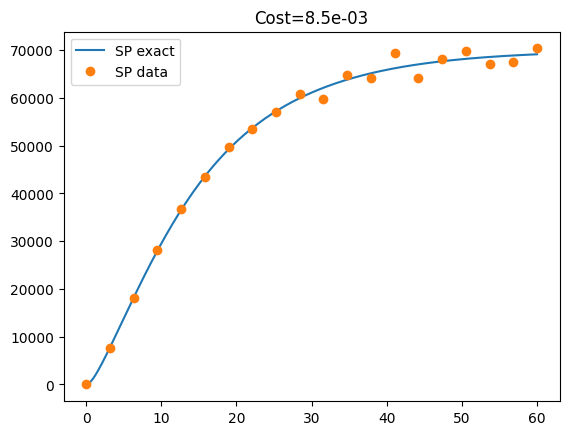

In [139]:
popt= 10**result.optimize_result.list[0]['x']
plot_comparison(popt)
#plot_comparison(pvals)
print(popt)
print(pvals)


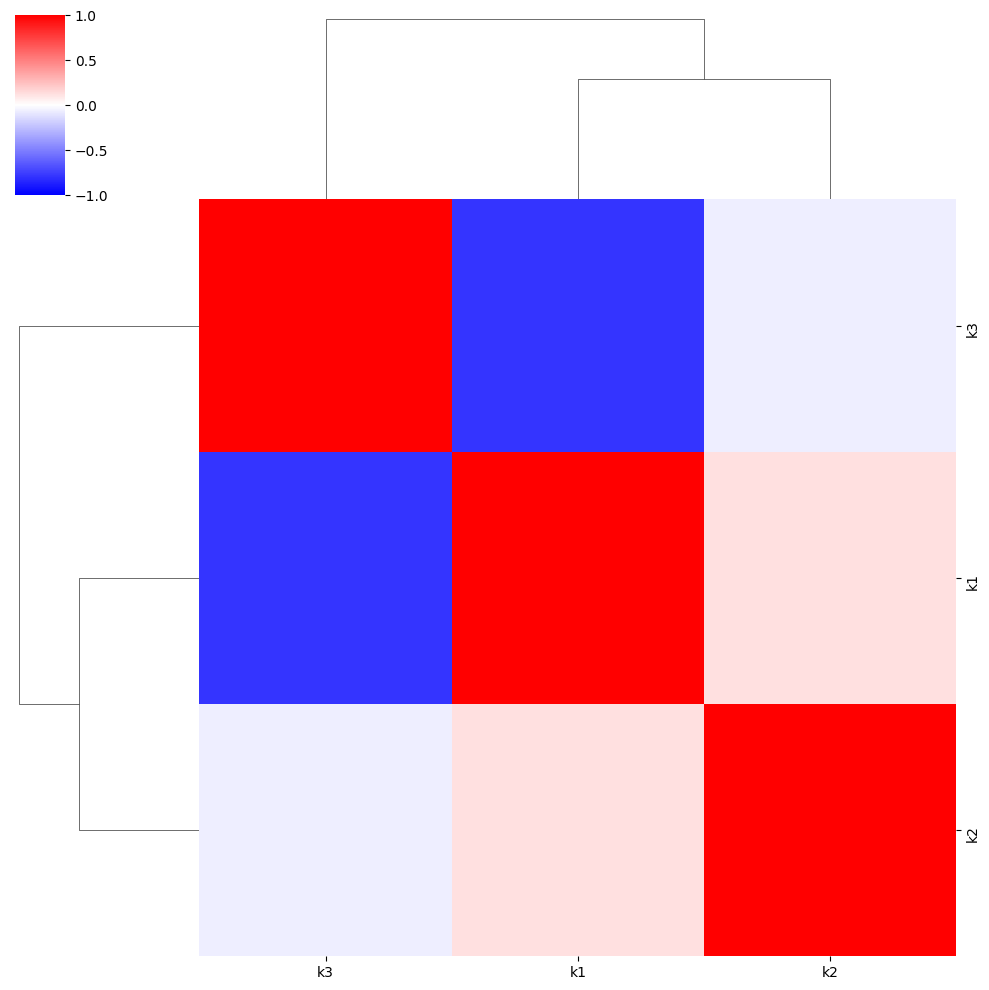

In [140]:
_= visualize.parameters_correlation_matrix(result)